<a href="https://colab.research.google.com/github/andyyPark/MachineLearning4Art/blob/main/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run this if you are in Colab

In [1]:
!git clone https://github.com/andyypark/MachineLearning4Art.git
%cd MachineLearning4Art/

Cloning into 'MachineLearning4Art'...
remote: Enumerating objects: 8387, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 8387 (delta 3), reused 17 (delta 2), pack-reused 8366
Receiving objects: 100% (8387/8387), 698.24 MiB | 28.00 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (8359/8359), done.
/content/MachineLearning4Art


In [2]:
import PIL
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

# Enable GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper Functions

In [4]:
def load_img(img_path, img_size=(420, 560)):
  loader = transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.ToTensor()
  ])
  image = PIL.Image.open(img_path)
  image = loader(image).unsqueeze(0) # Add extra dimension for vgg19
  return image.to(device, torch.float)

def plot_img(img_tensor):
  image = img_tensor.cpu().clone()
  image = image.squeeze(0)
  image = transforms.ToPILImage()(image)
  plt.imshow(image)
  plt.show()

Content Image


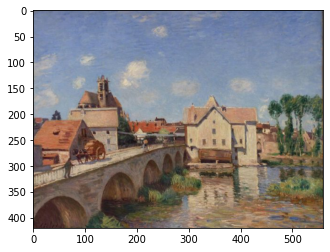

Style Image


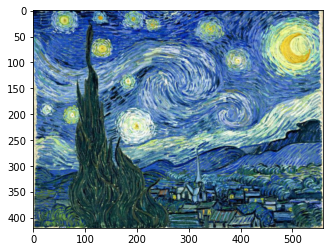

In [5]:
content_img = load_img("./data/resized/Alfred_Sisley_96.jpg")
style_img = load_img("./data/resized/Vincent_van_Gogh_368.jpg")

print('Content Image')
plot_img(content_img)

print('Style Image')
plot_img(style_img)

# Load VGG19 Model

In [6]:
vgg19 = models.vgg19(pretrained=True).features.to(device).eval()
print(vgg19)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [7]:
# https://pytorch.org/vision/stable/models.html
class Normalize(nn.Module):
  def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    super(Normalize, self).__init__()
    self.mean = torch.tensor(mean).to(device).view(-1, 1, 1)
    self.std = torch.tensor(std).to(device).view(-1, 1, 1)

  def forward(self, input):
    x = input - self.mean
    x = x / self.std
    return x

In [8]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.batch, self.Nl, self.height, self.width = target_feature.size()
    self.Ml = self.height * self.width
    self.target = self._gram_matrix(target_feature).detach()
    
  def _gram_matrix(self, input):
    features = input.view(self.batch * self.Nl, self.Ml)
    return torch.mm(features, torch.t(features))

  def forward(self, input):
    G = self._gram_matrix(input)
    denom = 4 * self.Nl ** 2 * self.Ml ** 2
    self.loss = F.mse_loss(G, self.target) / denom
    return input

In [22]:
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

In [29]:
def build_content_style_model(content_img, style_img, noise_img):
  content_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
  style_layers = content_layers

  content_losses = [] # List to keep track of loss of each content representation
  style_losses = []

  model = nn.Sequential(Normalize())
  i = 0 # Keeping track of number of conv2d

  for layer in vgg19.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = f"conv_{i}"
    elif isinstance(layer, nn.ReLU):
      name = f"relu_{i}"
      # https://github.com/NVlabs/FUNIT/issues/23
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = f"pool_{i}"

    model.add_module(name, layer)

    if name in content_layers:
      content_loss_name = f"content_loss_{i}"
      target_feature = model(content_img).detach()
      content_loss = ContentLoss(target_feature)
      model.add_module(content_loss_name, content_loss)
      content_losses.append(content_loss)

    if name in style_layers:
      style_loss_name = f"style_loss_{i}"
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module(style_loss_name, style_loss)
      style_losses.append(style_loss)
  
  # Remove layers after the last Style Loss
  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break

  model = model[:i+1]
  return model, content_losses, style_losses


In [37]:
def style_transfer(content_img, style_img, noise_img, iters):
  model, content_losses, style_losses = build_content_style_model(content_img,
                                                                  style_img,
                                                                  noise_img)
  optimizer = optim.LBFGS([noise_img])
  noise_img.requires_grad = True
  plot_img(noise_img)

  run = [0]
  while run[0] <= iters:
  
    def closure():
      noise_img.data.clamp_(0, 1)
      optimizer.zero_grad()

      model(noise_img)

      content_score = 0
      style_score = 0

      for content_loss in content_losses:
        content_score += content_loss.loss

      for style_loss in style_losses:
        style_score += style_loss.loss
      
      style_score *= 1e5
      loss = content_score + style_score

      loss.backward()

      run[0] += 1
      if run[0] % 50 == 0:
        plot_img(noise_img)
      
      return loss

    optimizer.step(closure)

  noise_img.data.clamp_(0, 1)
  return noise_img

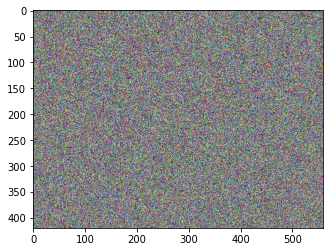

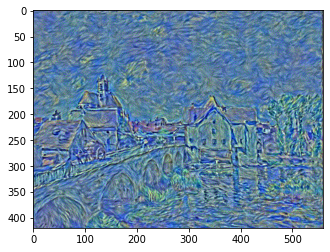

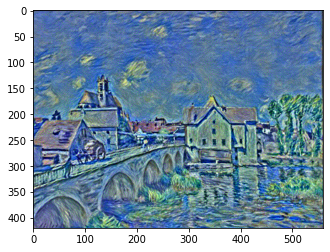

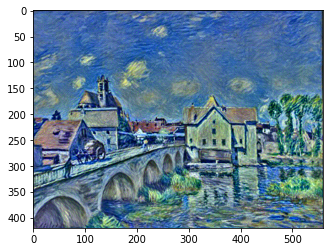

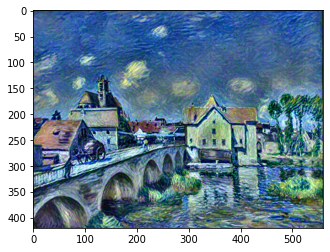

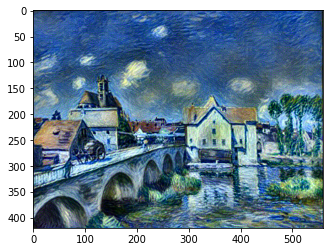

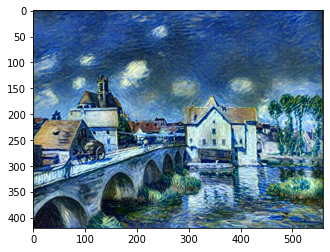

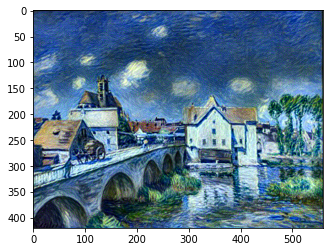

In [39]:
noise_img = torch.rand(style_img.size()).to(device)
output = style_transfer(content_img, style_img, noise_img, iters=350)